In [1]:
import numpy as np
import pandas as pd

In [2]:
df_a = pd.read_csv("data/psam_pusa.csv")
df_b = pd.read_csv("data/psam_pusb.csv")

KeyboardInterrupt: 

In [ ]:
df_p = pd.concat([df_a, df_b])

In [ ]:
# reading in the household PUMS for referencing purposes
dfh_a = pd.read_csv("data/psam_husa.csv")
dfh_b = pd.read_csv("data/psam_husb.csv")

In [ ]:
# combining the two parts of the household PUMS
df_h = pd.concat([dfh_a, dfh_b])

In [ ]:
del(df_a)
del(df_b)
del(dfh_a)
del(dfh_b)

In [ ]:
# cleaning missing identifier data
df_p["MIGPUMA"] = df_p["MIGPUMA"].fillna(0)
df_p["MIGSP"] = df_p["MIGSP"].fillna(0)

In [ ]:
# filtering out the PUMS to people 18+ who moved from places in the contiguous united states to other places in the contiguous united states
print(df_p.shape)
df_subset = df_p[df_p["AGEP"] >= 18]
print(df_subset.shape)
# 2 and 15 correspond to Alaska and Hawaii
df_subset = df_subset[(df_subset["MIGSP"] <= 56) & (df_subset["MIGSP"] != 2) & (df_subset["MIGSP"] != 15)]
print(df_subset.shape)
df_subset = df_subset[(df_subset["ST"] != 2) & (df_subset["ST"] != 15)]
print(df_subset.shape)

(3214539, 286)
(2562591, 286)
(2545881, 286)
(2530899, 286)


In [ ]:
# converting MIGPUMA and PUMA values to unique values
df_subset["MIGPUMA_st"] = df_subset["MIGSP"].astype(int).astype(str).str.zfill(2) + df_subset["MIGPUMA"].astype(int).astype(str).str.zfill(5)
df_subset["PUMA_st"] = df_subset["ST"].astype(str).str.zfill(2) + df_subset["PUMA"].astype(str).str.zfill(5)

In [ ]:
# adding stay field
df_subset["STAY"] = np.where(df_subset["MIGPUMA_st"] == "0000000", 1, 0)

In [ ]:
# renaming to make chosen destination/origin distinction clear
df_subset = df_subset.rename(columns={"PUMA_st": "CHOSEN", "MIGPUMA_st": "ORIGIN"})

In [ ]:
# including some household data into the individual data
temp = df_h[["FINCP", "GRNTP", "HINCP", "SMOCP", "SERIALNO", "TEN"]].groupby("SERIALNO").first()
df = pd.merge(df_subset, temp, left_on="SERIALNO", right_index=True, how="left")

In [ ]:
df["TEN"].value_counts()

1.0    1078581
2.0     677057
3.0     592651
4.0      38567
Name: TEN, dtype: int64

In [ ]:
# reading in PUMA-MIGPUMA equivalency data
puma_migpuma = pd.read_excel("data/puma_migpuma.xlsx", dtype="str")
puma_migpuma["PUMA"] = puma_migpuma["State"] + puma_migpuma["PUMA"]
puma_migpuma["MIGPUMA"] = puma_migpuma["State"] + puma_migpuma["MIGPUMA"]
# some MIGPUMA fields have footnotes
puma_migpuma["MIGPUMA"] = puma_migpuma["MIGPUMA"].str.strip("*")
puma_migpuma = puma_migpuma.set_index("PUMA")
puma_migpuma.head()

,State,MIGPUMA
PUMA,,
0100100,01,0100190
0100200,01,0100290
0100301,01,0100290
0100302,01,0100290
0100400,01,0100400


In [ ]:
df["ORIGIN"] = np.where(df["ORIGIN"] == "0000000", puma_migpuma.loc[df["CHOSEN"], "MIGPUMA"], df["ORIGIN"])

In [ ]:
df["UNEMP"] = np.where(df["ESR"] == 3, 1, 0)
df["EMP"] = np.where((df["ESR"] != 6) & (df["ESR"] != 3), 1, 0)

In [ ]:
df["HH_COST"] = np.where(df["TEN"] == 3, df["GRNTP"], df["SMOCP"])
df["HH_COST"] = df["HH_COST"] / df["HINCP"] * 12

In [ ]:
df_stay = df[df["STAY"] == 1]
df_leave = df[df["STAY"] == 0]

In [ ]:
df_leave.groupby("CHOSEN")["PINCP"].count().describe()

count    2336.000000
mean      140.404110
std        65.880232
min        25.000000
25%        96.000000
50%       130.000000
75%       167.250000
max       608.000000
Name: PINCP, dtype: float64

In [ ]:
leavers_puma = pd.concat([df_leave.groupby("CHOSEN")[["JWMNP", "FINCP", "GRNTP", "HINCP", "SMOCP", "PINCP", "HH_COST"]].median(), \
   df_leave.groupby("CHOSEN")[["UNEMP", "EMP"]].sum()], axis=1) 
leavers_puma["type"] = "leavers"

In [ ]:
df_leave.groupby("ORIGIN")["PINCP"].count().describe()

count     975.000000
mean      336.393846
std       557.163767
min        60.000000
25%       130.000000
50%       174.000000
75%       308.500000
max      8978.000000
Name: PINCP, dtype: float64

In [ ]:
leavers_migpuma = pd.concat([df_leave.groupby("ORIGIN")[["JWMNP", "FINCP", "GRNTP", "HINCP", "SMOCP", "PINCP"]].median(), \
   df_leave.groupby("ORIGIN")[["UNEMP", "EMP"]].sum()], axis=1) 
leavers_migpuma["type"] = "leavers"

In [ ]:
df_stay.groupby("CHOSEN")["PINCP"].count().describe()

count    2336.000000
mean      943.028682
std       306.989085
min       281.000000
25%       736.000000
50%       881.500000
75%      1093.500000
max      3210.000000
Name: PINCP, dtype: float64

In [ ]:
stayers_puma = pd.concat([df_stay.groupby("CHOSEN")[["JWMNP", "FINCP", "GRNTP", "HINCP", "SMOCP", "PINCP"]].median(), \
   df_stay.groupby("CHOSEN")[["UNEMP", "EMP"]].sum()], axis=1) 
stayers_puma["type"] = "stayers"

In [ ]:
df_stay.groupby("ORIGIN")["PINCP"].count().describe()

count      975.000000
mean      2259.400000
std       3709.927666
min        470.000000
25%        990.000000
50%       1302.000000
75%       2060.500000
max      72990.000000
Name: PINCP, dtype: float64

In [ ]:
stayers_migpuma = pd.concat([df_stay.groupby("ORIGIN")[["JWMNP", "FINCP", "GRNTP", "HINCP", "SMOCP", "PINCP", "HH_COST"]].median(), \
   df_stay.groupby("ORIGIN")[["UNEMP", "EMP"]].sum()], axis=1) 
stayers_migpuma["type"] = "stayers"

In [ ]:
stayers_migpuma.to_csv("data/stay_migpuma.csv")
leavers_puma.to_csv("data/leave_puma.csv")

In [ ]:
stayers_migpuma = stayers_migpuma.drop("HH_COST", axis=1)
leavers_puma = leavers_puma.drop("HH_COST", axis=1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
stayers_migpuma.iloc[:, 0]

ORIGIN
0100190    20.0
0100290    20.0
0100400    20.0
0100600    20.0
0100700    20.0
           ... 
5600100    10.0
5600200    10.0
5600300    10.0
5600400    15.0
5600500    10.0
Name: JWMNP, Length: 975, dtype: float64

<AxesSubplot:xlabel='JWMNP', ylabel='type'>

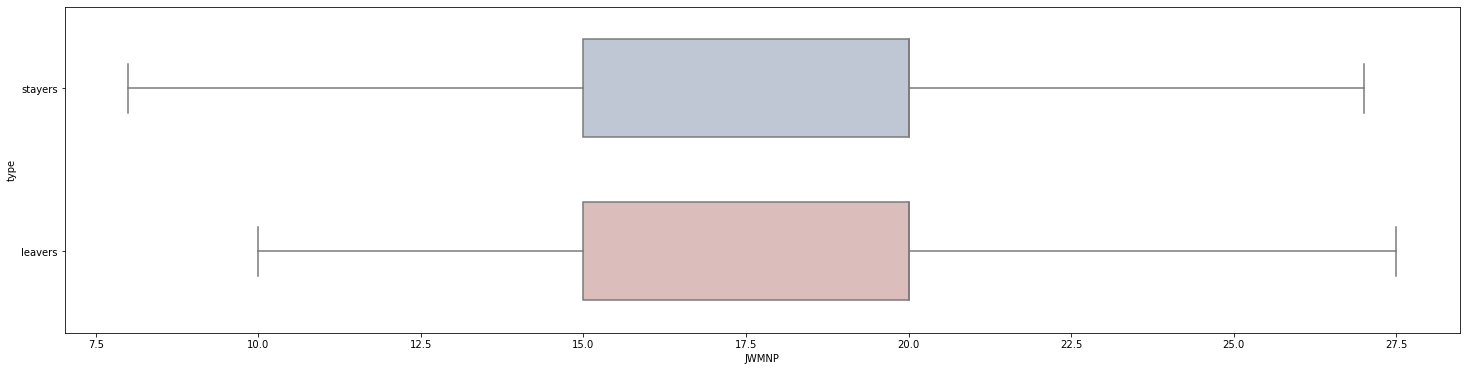

In [ ]:
# travel time
temp = pd.concat([stayers_migpuma.iloc[:, [0, 8]], leavers_migpuma.iloc[:, [0, 8]]])

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='FINCP', ylabel='type'>

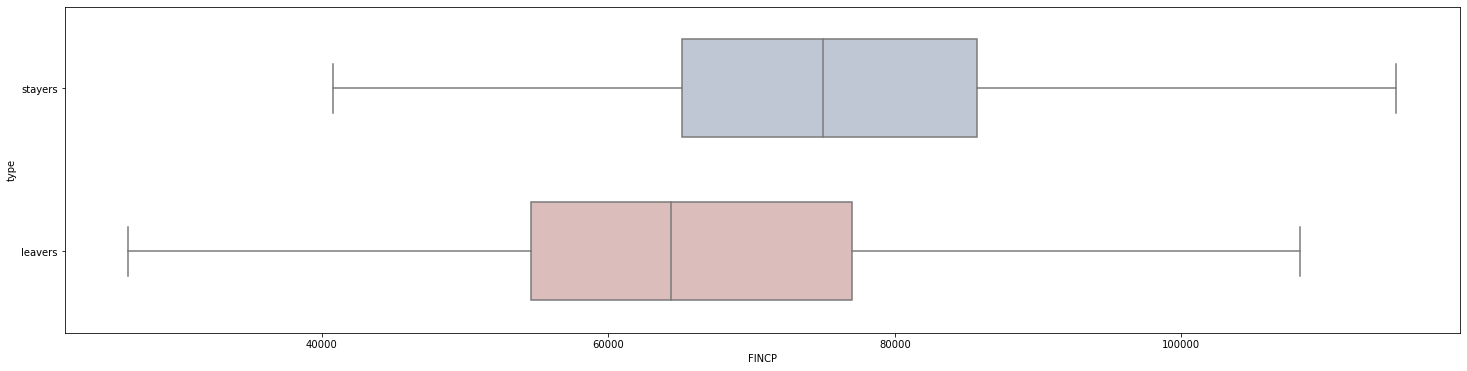

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [1, 8]], leavers_migpuma.iloc[:, [1, 8]]])

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='GRNTP', ylabel='type'>

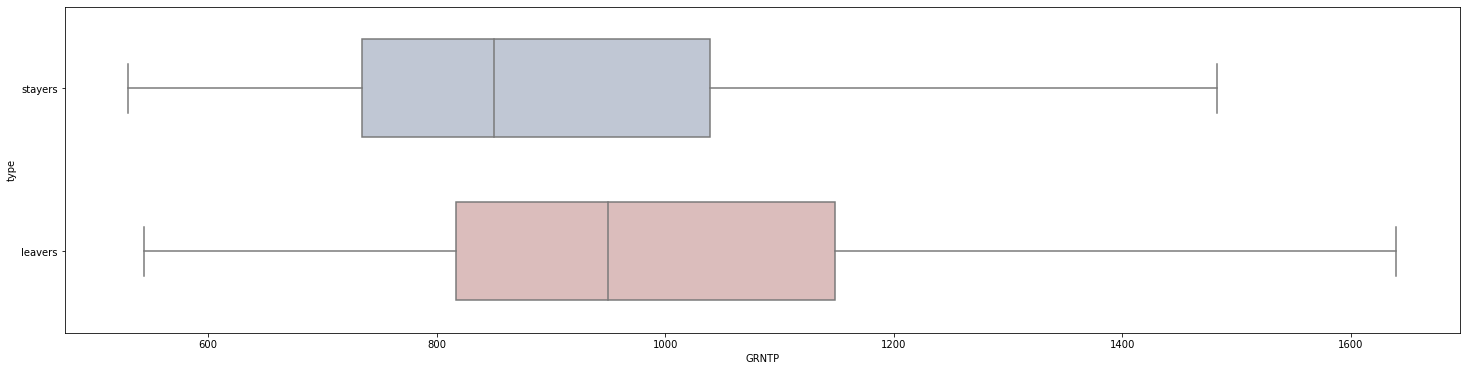

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [2, 8]], leavers_migpuma.iloc[:, [2, 8]]])

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='HINCP', ylabel='type'>

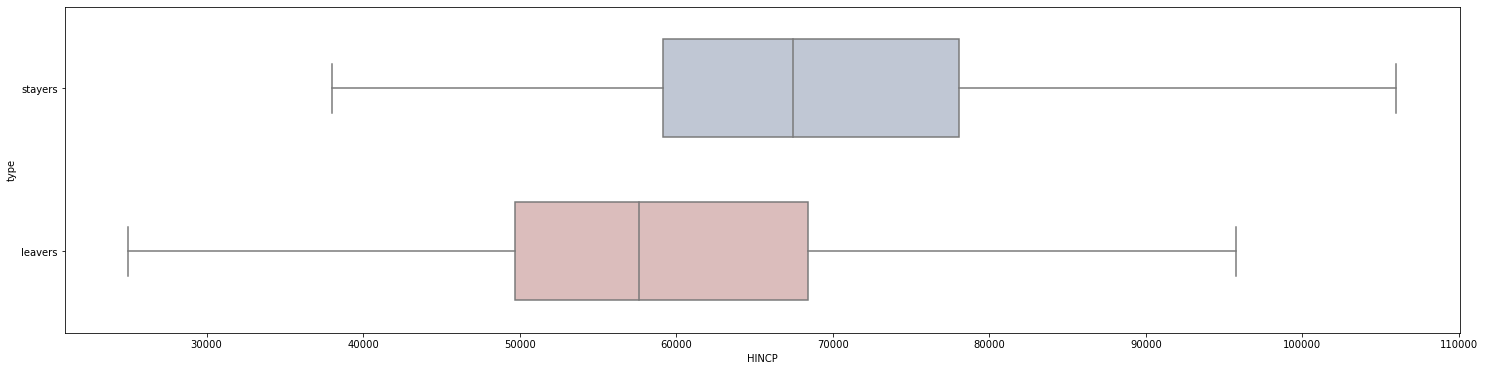

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [3, 8]], leavers_migpuma.iloc[:, [3, 8]]])

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='SMOCP', ylabel='type'>

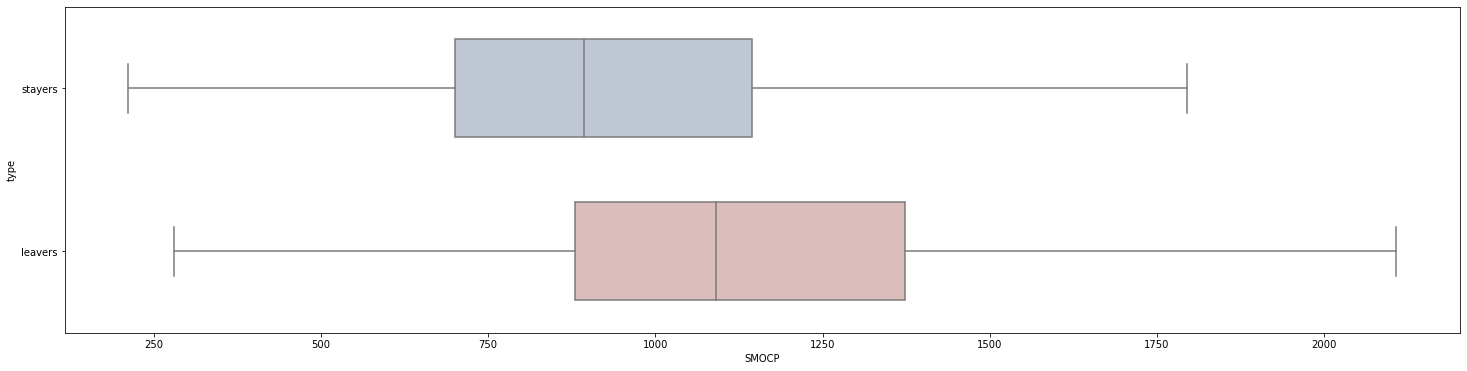

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [4, 8]], leavers_migpuma.iloc[:, [4, 8]]])

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='PINCP', ylabel='type'>

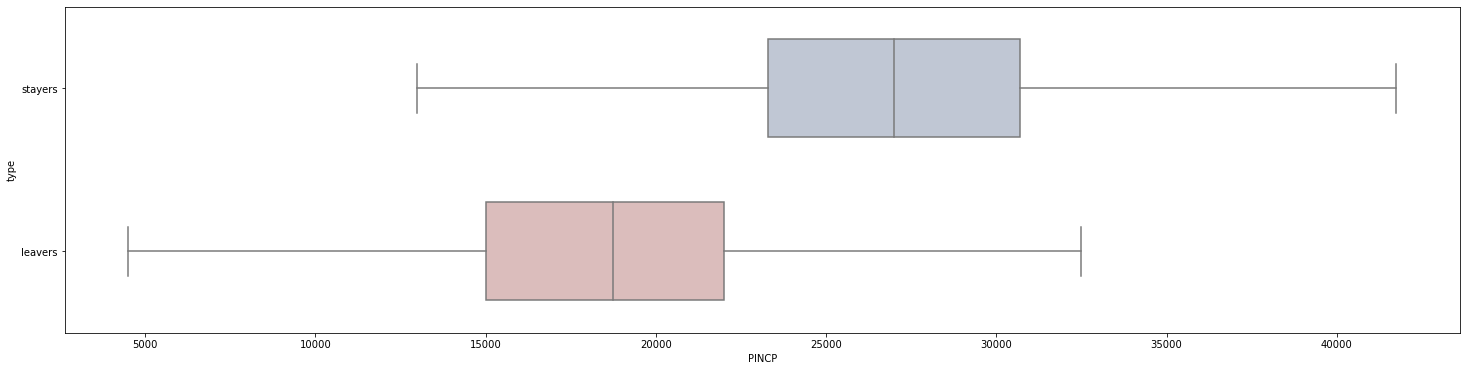

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [5, 8]], leavers_migpuma.iloc[:, [5, 8]]])

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:ylabel='type'>

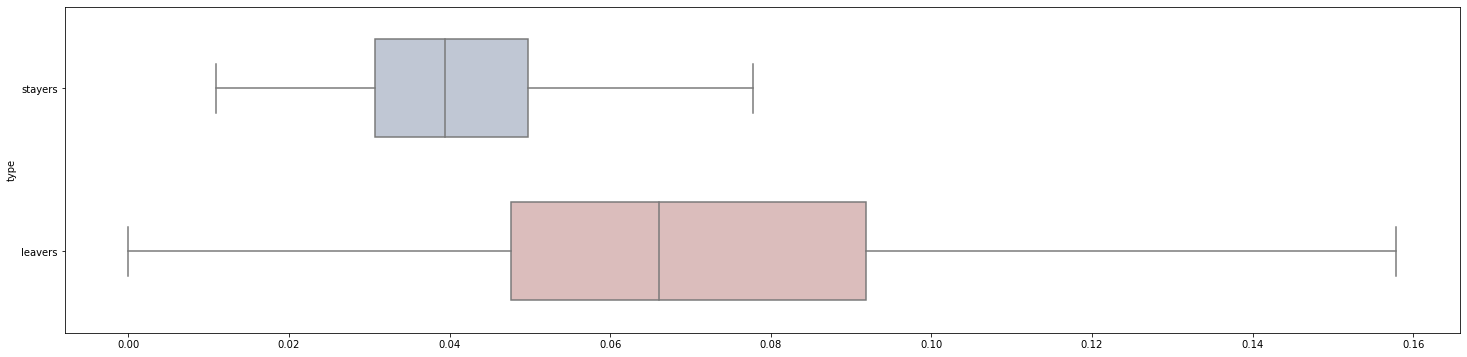

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, 6:], leavers_migpuma.iloc[:, 6:]])
temp

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp["UNEMP"] / temp["EMP"], y=temp.iloc[:, 2], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='JWMNP', ylabel='type'>

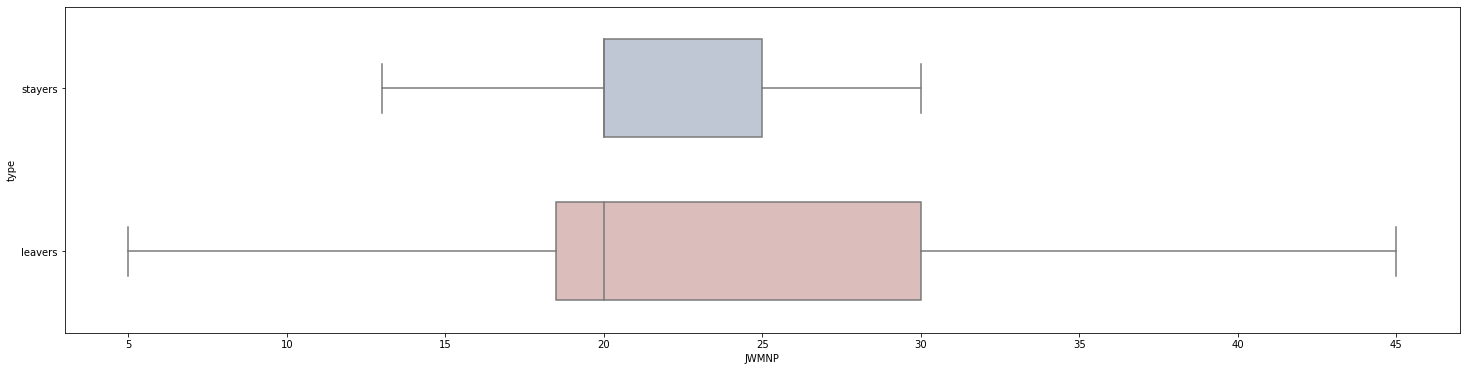

In [ ]:
# travel time
temp = pd.concat([stayers_puma.iloc[:, [0, 8]], leavers_puma.iloc[:, [0, 8]]])

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp["JWMNP"], y=temp["type"], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='FINCP', ylabel='type'>

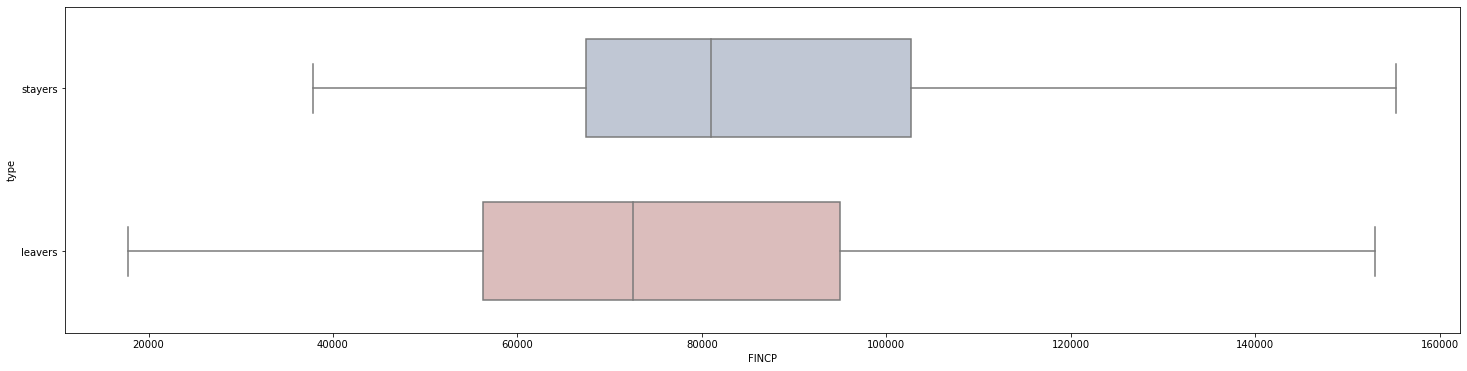

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [1, 8]], leavers_puma.iloc[:, [1, 8]]])
temp

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='GRNTP', ylabel='type'>

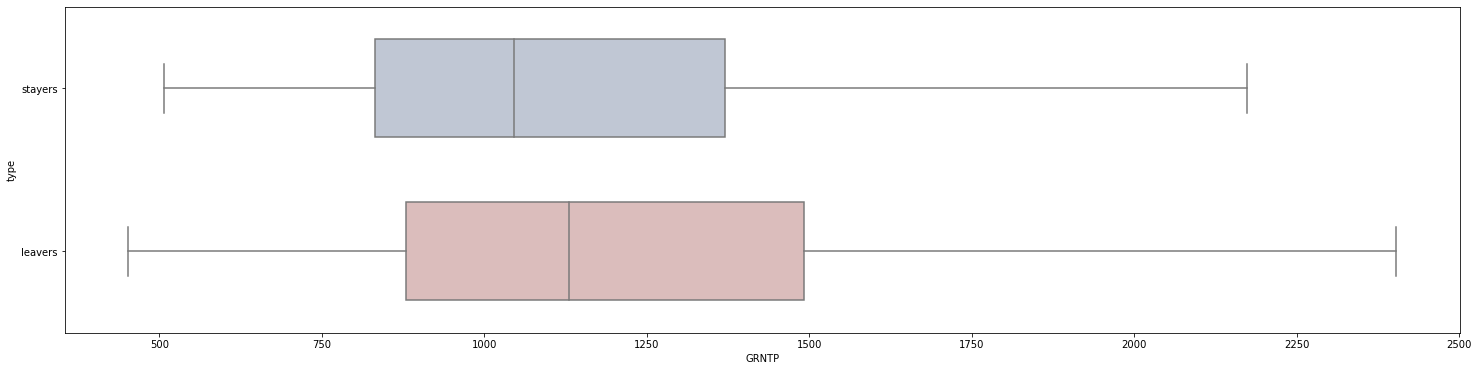

In [ ]:
# travel time
temp = pd.concat([stayers_puma.iloc[:, [2, 8]], leavers_puma.iloc[:, [2, 8]]])
temp

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='GRNTP', ylabel='type'>

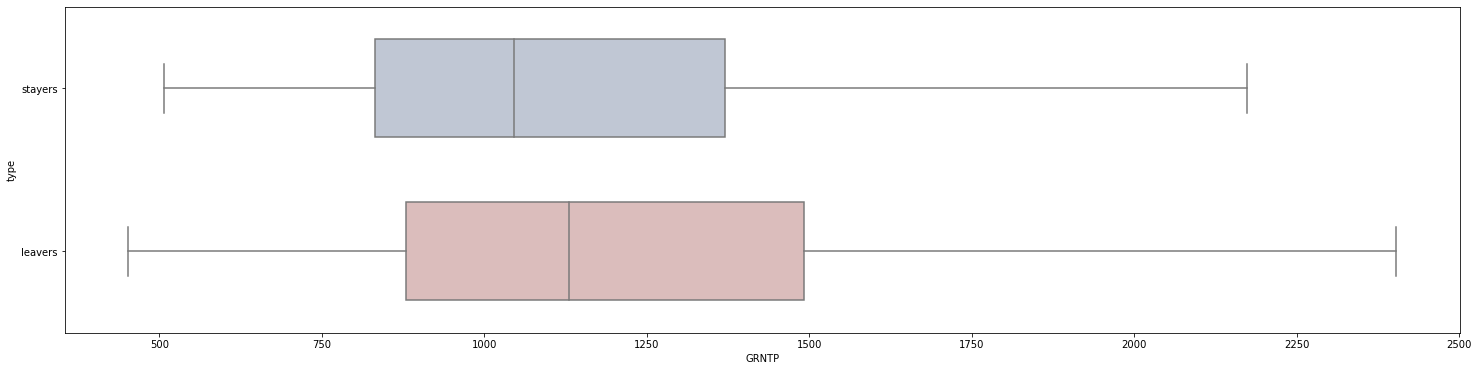

In [ ]:
# travel time
temp = pd.concat([stayers_puma.iloc[:, [2, 8]], leavers_puma.iloc[:, [2, 8]]])
temp

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='HINCP', ylabel='type'>

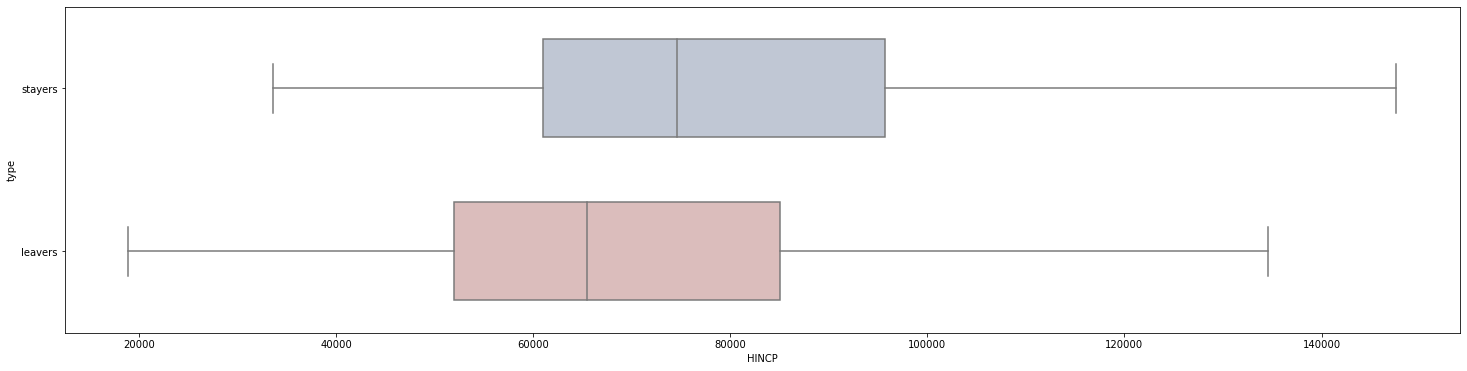

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [3, 8]], leavers_puma.iloc[:, [3, 8]]])
temp

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='SMOCP', ylabel='type'>

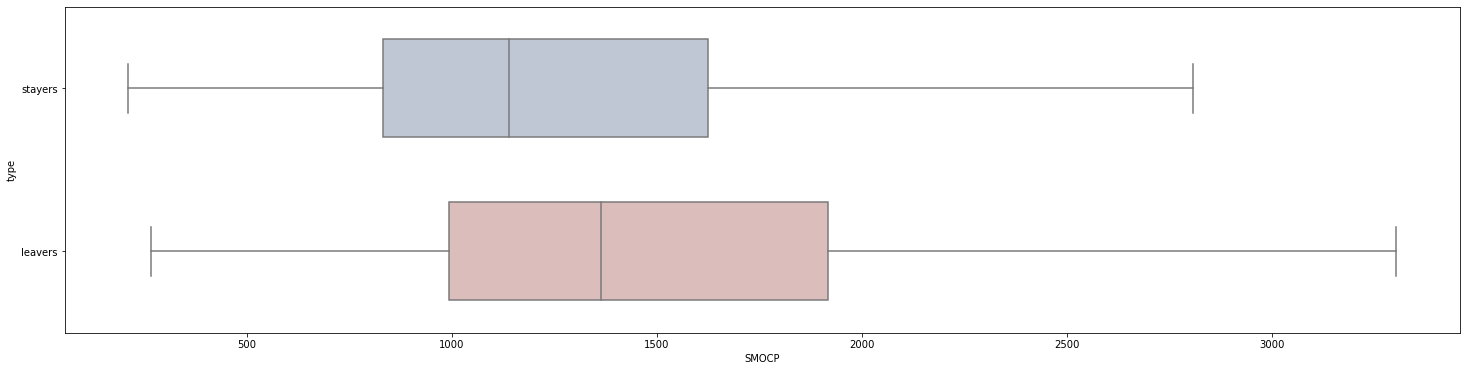

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [4, 8]], leavers_puma.iloc[:, [4, 8]]])
temp

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:xlabel='PINCP', ylabel='type'>

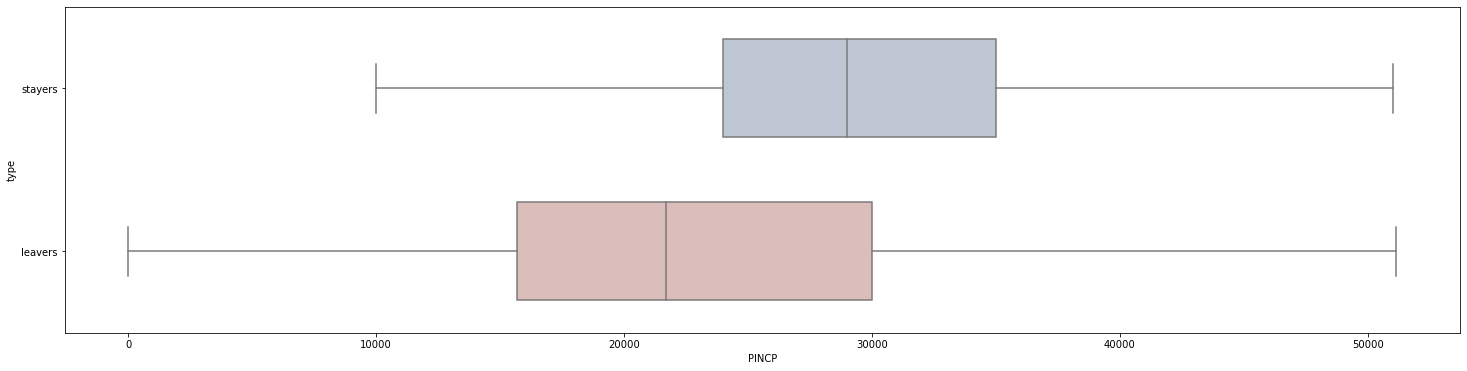

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [5, 8]], leavers_puma.iloc[:, [5, 8]]])
temp

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp.iloc[:, 0], y=temp.iloc[:, 1], width=.6, palette="vlag", orient="h", showfliers=False)

<AxesSubplot:ylabel='type'>

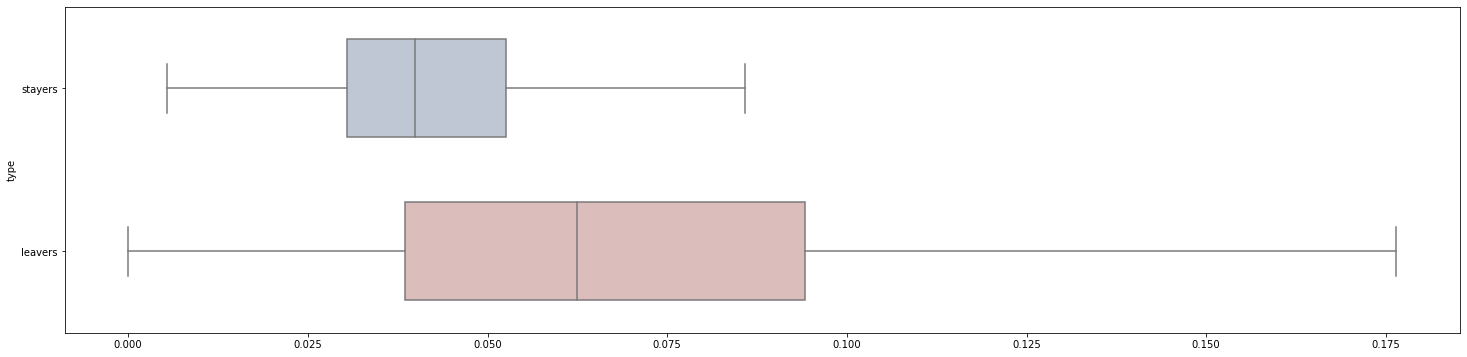

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, 6:], leavers_puma.iloc[:, 6:]])
temp

f, ax = plt.subplots(figsize=(25, 6))
sns.boxplot(x=temp["UNEMP"] / temp["EMP"], y=temp.iloc[:, 2], width=.6, palette="vlag", orient="h", showfliers=False)

In [ ]:
leavers_puma[leavers_puma["UNEMP"] == 0]

,JWMNP,FINCP,GRNTP,HINCP,SMOCP,PINCP,UNEMP,EMP,type
CHOSEN,,,,,,,,,
0400120,25.0,105000.0,1299.5,100000.0,1826.5,40000.0,0,81,leavers
0501200,20.0,70000.0,862.0,64900.0,1140.0,29500.0,0,39,leavers
0603719,25.0,120000.0,1984.0,93700.0,4297.0,25000.0,0,74,leavers
0603755,30.0,82030.0,1825.0,90400.0,1792.0,24500.0,0,50,leavers
0605916,20.0,63500.0,1630.0,75605.0,1347.0,22000.0,0,44,leavers
...,...,...,...,...,...,...,...,...,...
5159304,30.0,122750.0,2430.0,120700.0,2478.0,45750.0,0,76,leavers
5500300,15.0,100560.0,981.0,82410.0,1465.0,25000.0,0,64,leavers
5501301,15.0,67300.0,805.0,67300.0,1146.0,24525.0,0,54,leavers


Text(0, 0.5, 'Leaver FINCP')

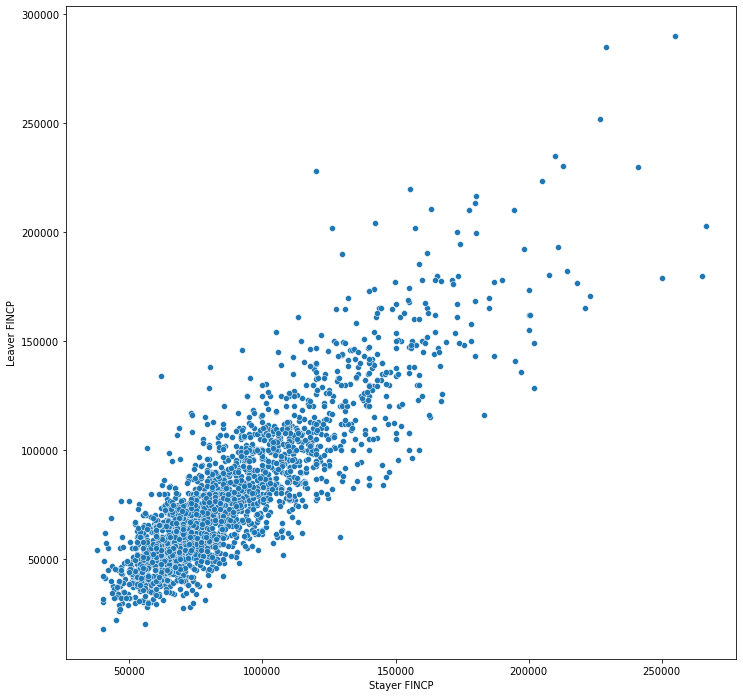

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [1, 8]], leavers_puma.iloc[:, [1, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver JWMNP')

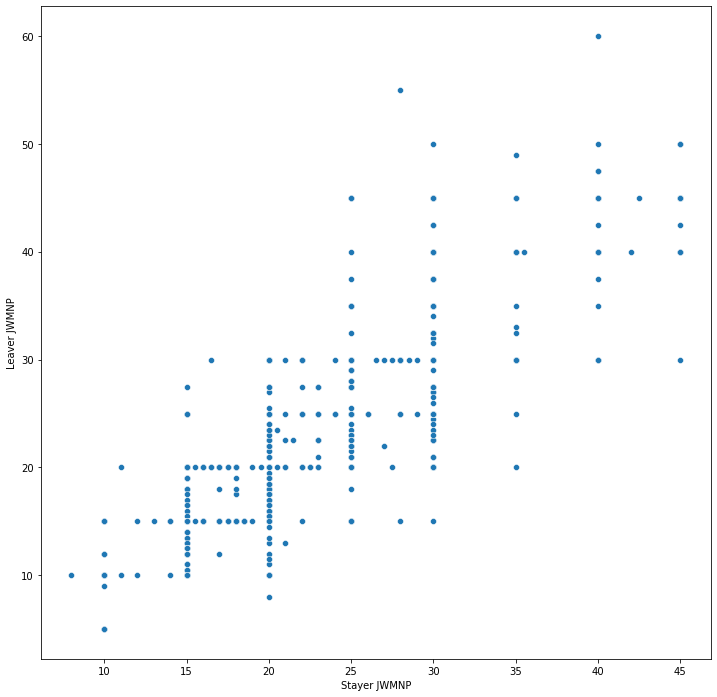

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [0, 8]], leavers_puma.iloc[:, [0, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver GRNTP')

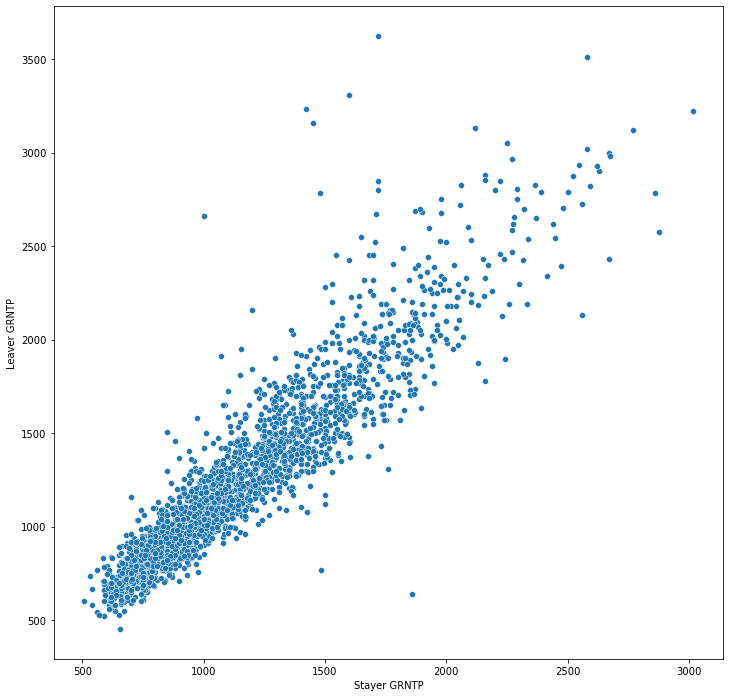

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [2, 8]], leavers_puma.iloc[:, [2, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver HINCP')

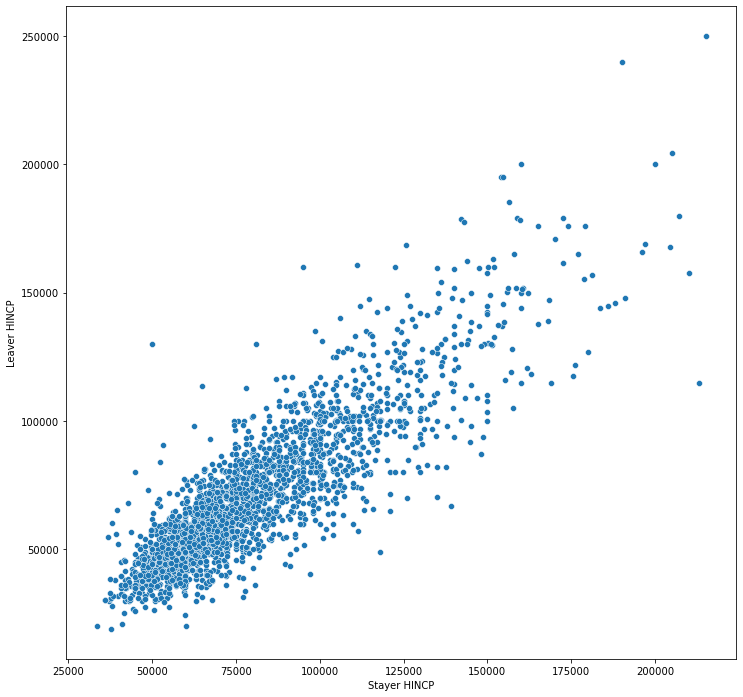

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [3, 8]], leavers_puma.iloc[:, [3, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver SMOCP')

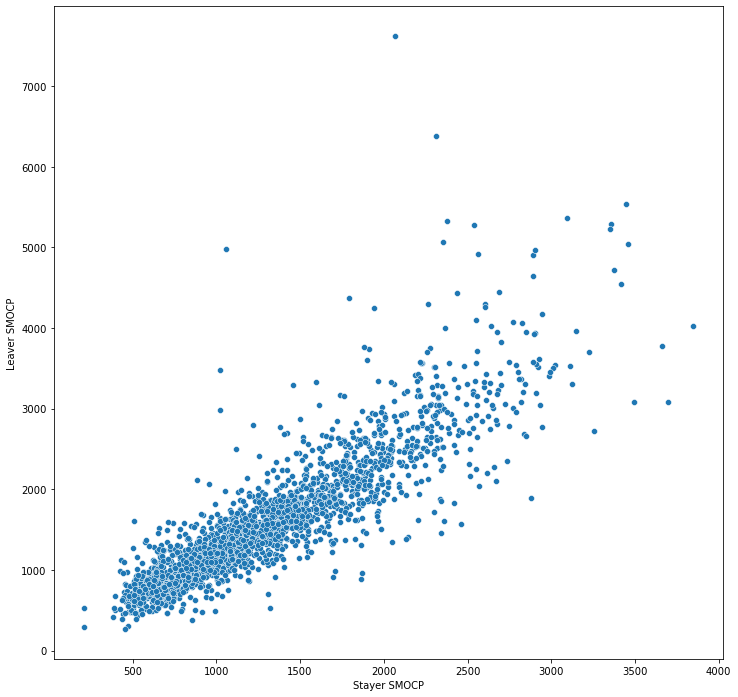

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [4, 8]], leavers_puma.iloc[:, [4, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver PINCP')

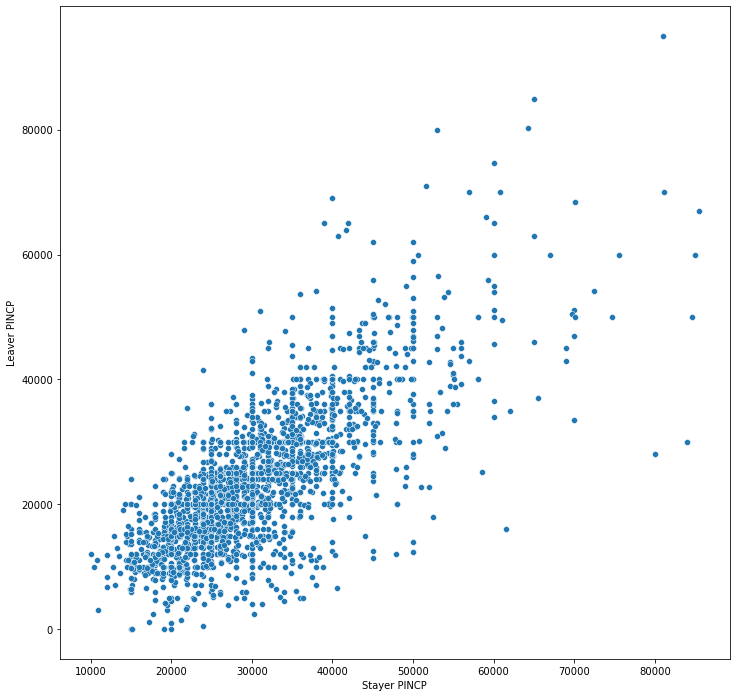

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [5, 8]], leavers_puma.iloc[:, [5, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver ')

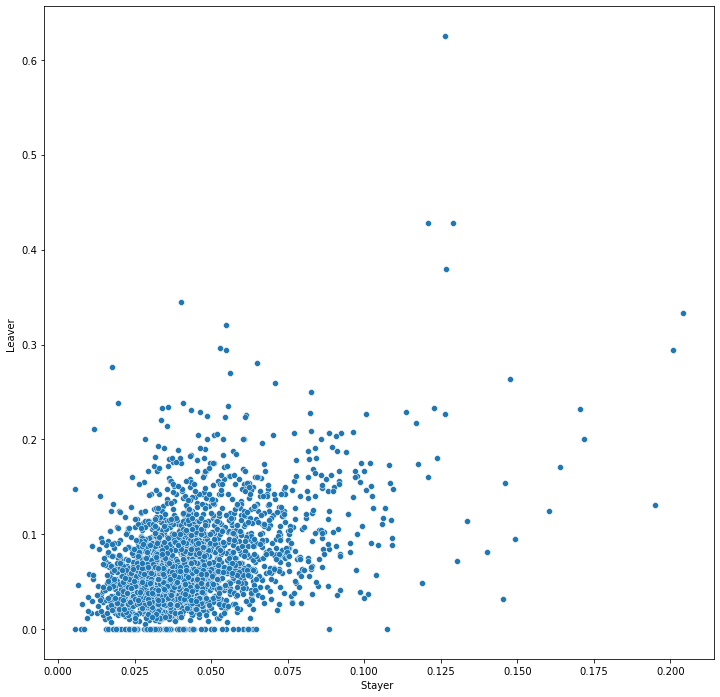

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, 6:9], leavers_puma.iloc[:, 6:9]], axis=1)
temp

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0] / temp.iloc[:, 1], y=temp.iloc[:, 3] / temp.iloc[:, 4])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver ')

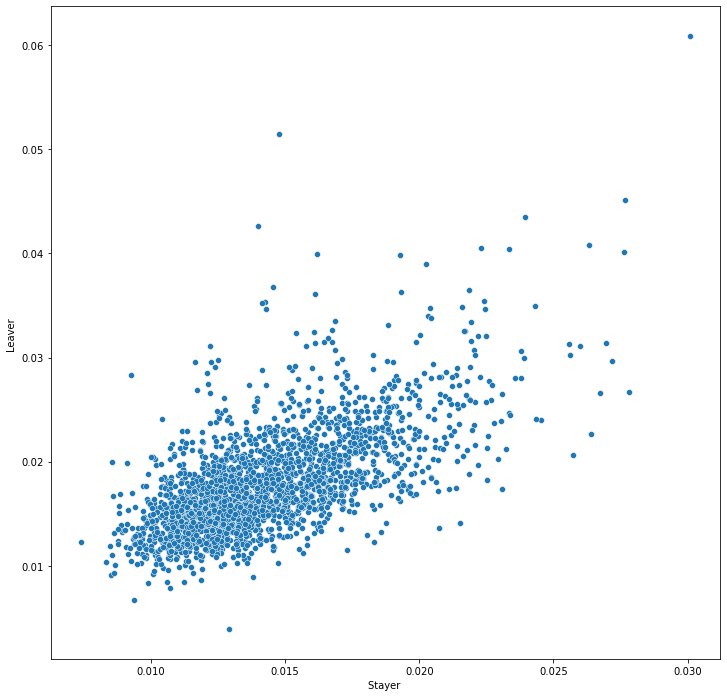

In [ ]:
temp = pd.concat([stayers_puma.iloc[:, [2, 3, 8]], leavers_puma.iloc[:, [2, 3, 8]]], axis=1)
temp

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0] / temp.iloc[:, 1], y=temp.iloc[:, 3] / temp.iloc[:, 4])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver FINCP')

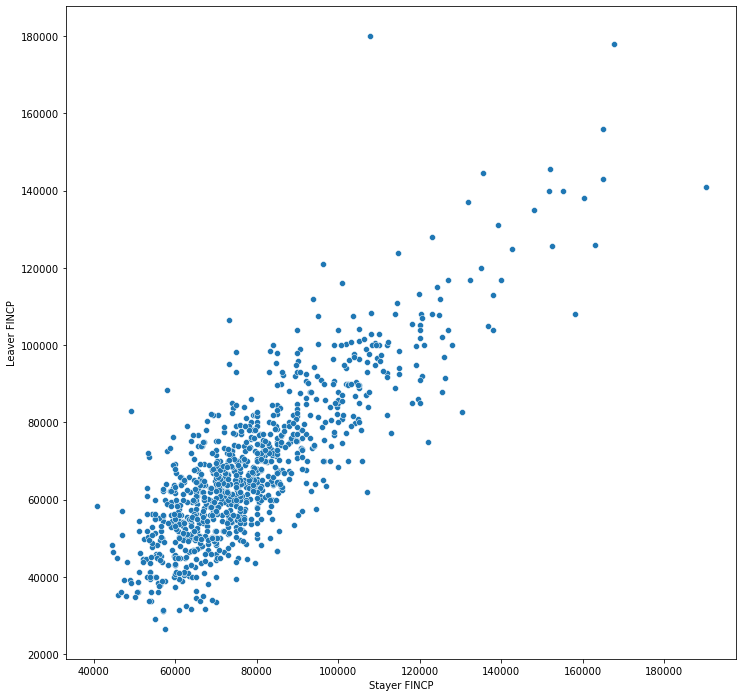

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [1, 8]], leavers_migpuma.iloc[:, [1, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver JWMNP')

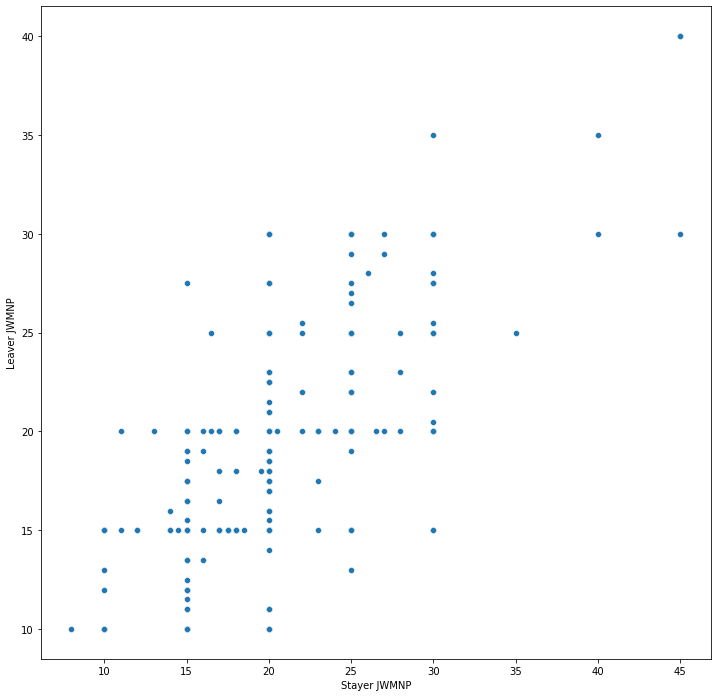

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [0, 8]], leavers_migpuma.iloc[:, [0, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver GRNTP')

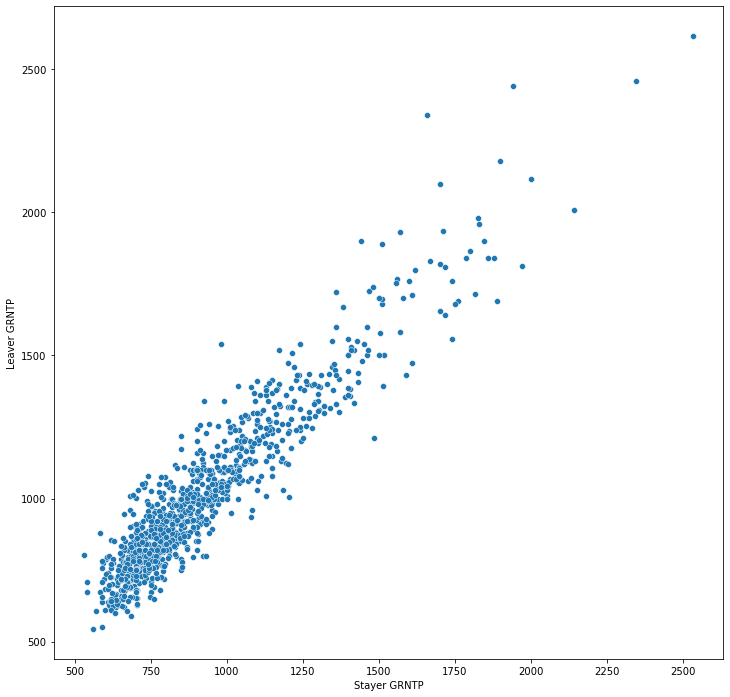

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [2, 8]], leavers_migpuma.iloc[:, [2, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver HINCP')

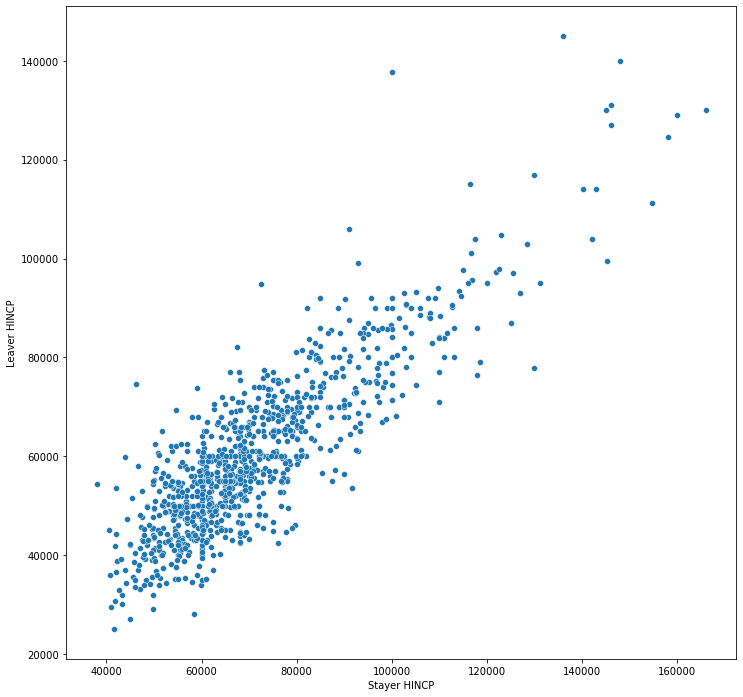

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [3, 8]], leavers_migpuma.iloc[:, [3, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver SMOCP')

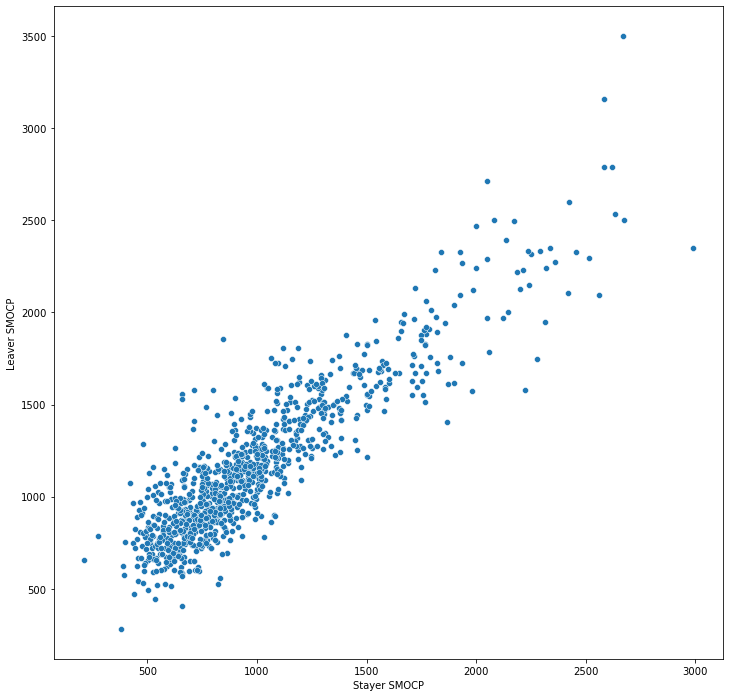

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [4, 8]], leavers_migpuma.iloc[:, [4, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver PINCP')

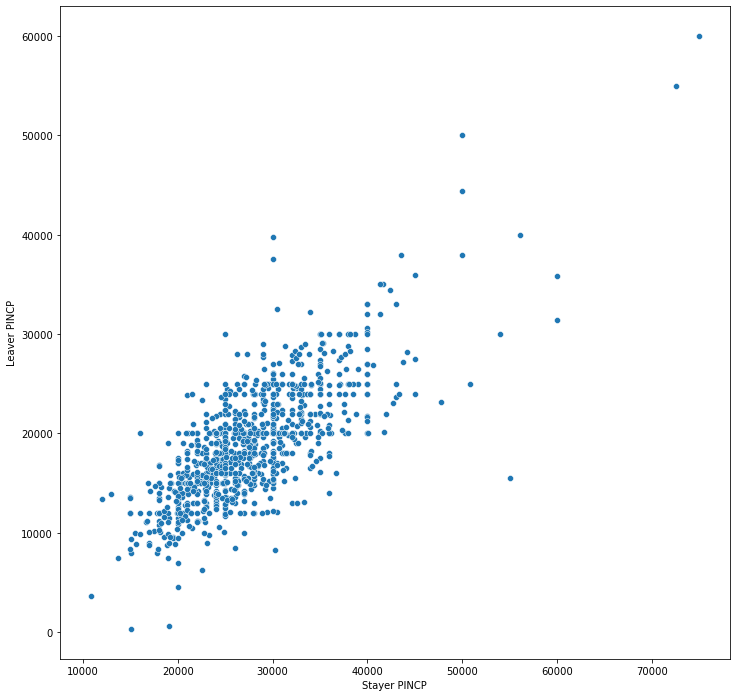

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [5, 8]], leavers_migpuma.iloc[:, [5, 8]]], axis=1)

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0], y=temp.iloc[:, 2])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver ')

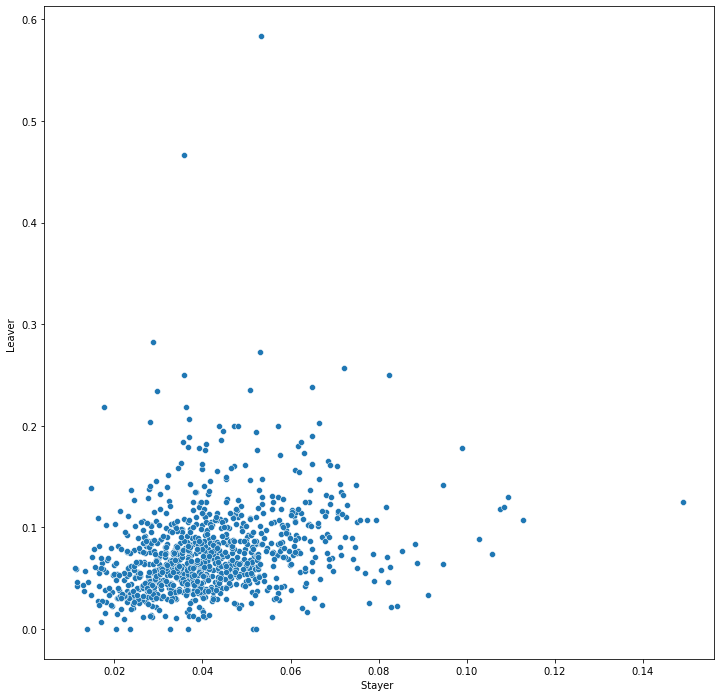

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, 6:9], leavers_migpuma.iloc[:, 6:9]], axis=1)
temp

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0] / temp.iloc[:, 1], y=temp.iloc[:, 3] / temp.iloc[:, 4])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)

Text(0, 0.5, 'Leaver ')

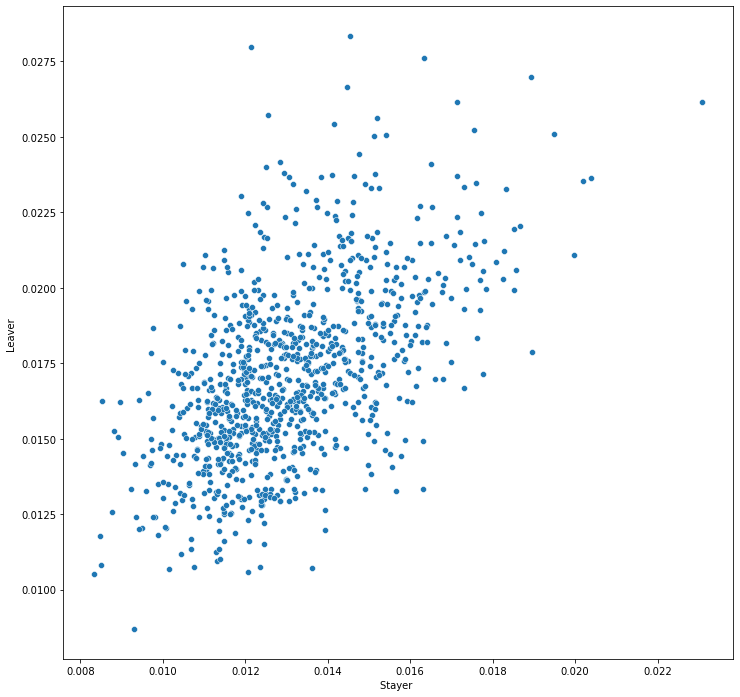

In [ ]:
temp = pd.concat([stayers_migpuma.iloc[:, [2, 3, 8]], leavers_migpuma.iloc[:, [2, 3, 8]]], axis=1)
temp

f, ax = plt.subplots(figsize=(12, 12))
ax = sns.scatterplot(x=temp.iloc[:, 0] / temp.iloc[:, 1], y=temp.iloc[:, 3] / temp.iloc[:, 4])
label = ax.get_xlabel()
plt.xlabel("Stayer " + label)
plt.ylabel("Leaver " + label)